<a href="https://colab.research.google.com/github/rinkideo/datascience_projects/blob/master/plant_seedling_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install kaggle

In [0]:
## Uploading the Credentials of Kaggle Account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"rinkideo","key":"1658ef933c978ae41b75678200fcfd35"}'}

In [0]:

"""'
DOWNLOAD THE KAGGLE.JSON FILE
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. 
Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. 
This will trigger the download of kaggle.json, a file containing your API credentials. 
Place this file in the location ~/.kaggle/kaggle.json (on Windows in the location in the location C:\Users\<Windows-username>\
"""
## make a directory  .kaggle (in the location C:\Users\<Windows-username>\.kaggle) and move or copy the downloaded kaggle.json file in this directoryin the location
## C:\Users\<Windows-username>\kaggle.json


In [0]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
##Import the required dataset for the project from Kaggle
## !kaggle competitions download -c plant-seedlings-classification

You can increase the memory allocation to ~25.51 GB RAM and GPU to ~ 16 GB by running the following command.
d=[]
while(1):
  d.append('1')
   You can then check the GPU allocated by running the following command.
!nvidia-smi

In [0]:
import zipfile as zf
seedling_data_zip = zf.ZipFile('/content/drive/My Drive/Colab Notebooks/plant-seedlings-classification.zip')
seedling_data_zip.extractall()
!ls

drive  sample_data  sample_submission.csv  test  train


In [0]:
train_data_path = '/content/train'
test_data_path  =  '/content/test'

In [13]:
 os.listdir(train_data_path)

['Maize',
 'Shepherds Purse',
 'Common wheat',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Loose Silky-bent',
 'Common Chickweed',
 'Black-grass',
 'Sugar beet',
 'Charlock',
 'Cleavers']

In [0]:
import os,sys
from glob import glob
import cv2
images = []
class_label = []
for class_folder_name in os.listdir(train_data_path):
    class_folder_path = os.path.join(train_data_path, class_folder_name)
    class_name = class_folder_name
    
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_rgb = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images.append(image_rgb)
        class_label.append(class_name)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
import numpy as np
import pandas as pd
#----------------------------------------------------------------

from keras.utils import np_utils, to_categorical 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
from collections import Counter
images_per_class = dict(Counter(class_label))

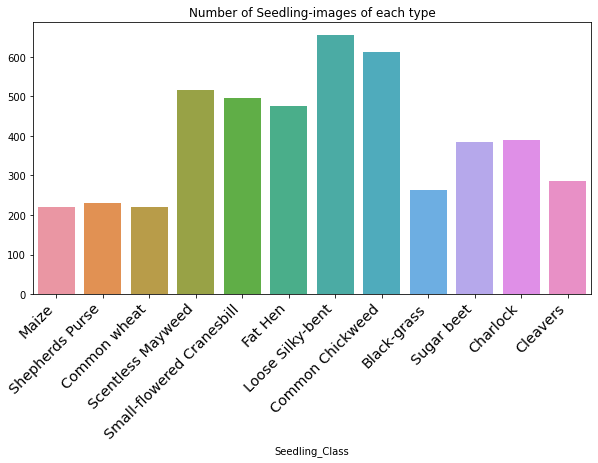

In [17]:
plt.figure(figsize=(10,5))
class_plot = sns.barplot(x = list(images_per_class.keys()), y = list(images_per_class.values()))
plt.title("Number of Seedling-images of each type")

plt.xlabel("Seedling_Class")
class_plot.set_xticklabels(class_plot.get_xticklabels(), 
                           rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show(class_plot)


In [41]:
len(images)

4750

In [24]:
images_per_class

{'Black-grass': 263,
 'Charlock': 390,
 'Cleavers': 287,
 'Common Chickweed': 611,
 'Common wheat': 221,
 'Fat Hen': 475,
 'Loose Silky-bent': 654,
 'Maize': 221,
 'Scentless Mayweed': 516,
 'Shepherds Purse': 231,
 'Small-flowered Cranesbill': 496,
 'Sugar beet': 385}

In [0]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

In [47]:
#save resized images into images.
images1 = [resize_images(img) for img in images]
images1[0].shape

(256, 256, 3)

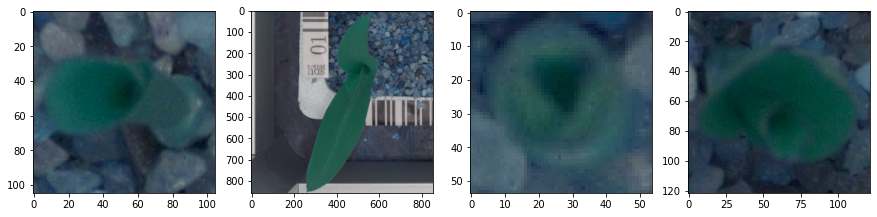

In [50]:
## Before resizing
fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(images[0])
axs[1].imshow(images[10])
axs[2].imshow(images[42])
axs[3].imshow(images[65])

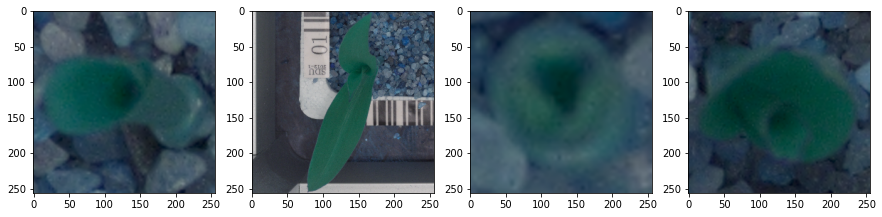

In [49]:
## After resizing
fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(images1[0])
axs[1].imshow(images1[10])
axs[2].imshow(images1[42])
axs[3].imshow(images1[65])

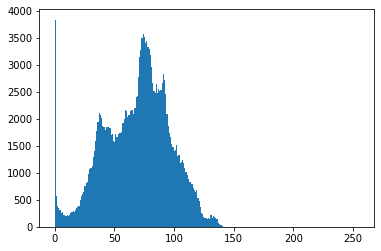

In [52]:

plt.hist(images1[0].ravel(),256,[0,255])
plt.show()

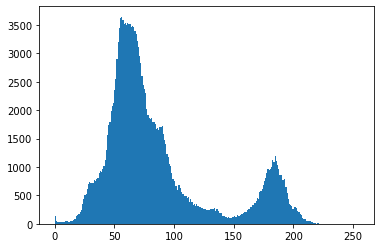

In [56]:
plt.hist(images1[10].ravel(),256,[0,255])
plt.show()

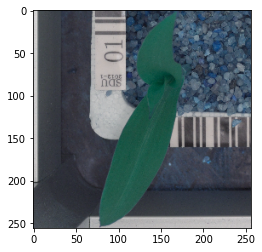

In [58]:
plt.imshow(images1[10])

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [0]:
def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [0]:
for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue

In [69]:
image = images[class_label == "Maize"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

error: ignored